In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

In [ ]:
from src.augmentations import AugsCreation
from src.baseline_config import TaskConfig
from src.baseline_model import CRNN
from src.collator import Collator
from src.dataset import SpeechCommandDataset
from src.dkd_config import DistillationTaskConfig
from src.logmelspec import LogMelspec
from src.trainers import train_epoch, train_epoch_distillation, validation
from src.utils import get_sampler, count_FA_FR, get_au_fa_fr

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-21 09:39:50--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   168MB/s    in 9.1s    

2021-11-21 09:40:00 (156 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [ ]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)
dataset.csv.sample(5)

,path,keyword,label
23065,speech_commands/on/6f2c6f7e_nohash_1.wav,on,0
31296,speech_commands/right/71e6ab20_nohash_0.wav,right,0
34874,speech_commands/two/b49caed3_nohash_0.wav,two,0
48563,speech_commands/tree/efa16ffd_nohash_0.wav,tree,0
36092,speech_commands/two/300384f0_nohash_1.wav,two,0


In [ ]:
torch.manual_seed(42)
use_gpu = torch.cuda.is_available()
if use_gpu:
    torch.cuda.manual_seed_all(42)

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

In [ ]:
train_sampler = get_sampler(train_set.csv['label'].values)
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

In [ ]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

In [ ]:
# !pip install thop

from thop import profile
profile(CRNN(config).to(config.device), (torch.randn(128, 40, 101).to(config.device), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.baseline_model.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.baseline_model.CRNN'>. Treat it as zero Macs and zero Params.


(119527424.0, 70443.0)

In [ ]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

70443

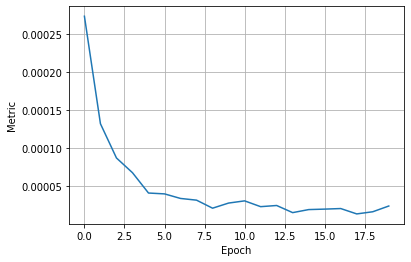

CURRENT METRIC VALUE: 2.4126794870475127e-05
END OF EPOCH 19


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('CURRENT METRIC VALUE:', au_fa_fr)
    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0002729496588129265,
              0.0001320021524944125,
              8.712022713679603e-05,
              6.77973080691239e-05,
              4.115220811941541e-05,
              4.003030917416452e-05,
              3.404485895029943e-05,
              3.1807028607378784e-05,
              2.1274307126698944e-05,
              2.7999733250623123e-05,
              3.0876091184723794e-05,
              2.3279403113955843e-05,
              2.4807095294723005e-05,
              1.545594823510526e-05,
              1.9454205114456816e-05,
              2.0056927420150112e-05,
              2.0808838415371453e-05,
              1.3767132269647814e-05,
              1.660171737068063e-05,
              2.4126794870475127e-05]})

In [ ]:
# !mkdir saved
# torch.save(model.state_dict(), 'saved/teacher_model.pth')

## Dark Knowledge Distillation

### out channels 4, hidden_size 16

In [ ]:
# model.load_state_dict(torch.load('saved/teacher_model.pth'))

<All keys matched successfully>

In [ ]:
torch.manual_seed(42)
use_gpu = torch.cuda.is_available()
if use_gpu:
    torch.cuda.manual_seed_all(42)

train_sampler = get_sampler(train_set.csv['label'].values)
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=64,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=64,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

dkd_config_4_16 = DistillationTaskConfig(batch_size=64, cnn_out_channels=4, kernel_size=(5, 20), stride=(2, 8), num_epochs=30, temperature=4, alpha=0.5)

In [ ]:
profile(CRNN(dkd_config_4_16).to(dkd_config_4_16.device), (torch.randn(128, 40, 101).to(dkd_config_4_16.device), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.baseline_model.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.baseline_model.CRNN'>. Treat it as zero Macs and zero Params.


(19321856.0, 6679.0)

In [ ]:
model_dkd_4_16 = CRNN(dkd_config_4_16).to(dkd_config_4_16.device)

opt = torch.optim.Adam(
    model_dkd_4_16.parameters(),
    lr=dkd_config_4_16.learning_rate,
    weight_decay=dkd_config_4_16.weight_decay
)

sum([p.numel() for p in model_dkd_4_16.parameters()])

6679

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

distill_melspec_train = LogMelspec(is_train=True, config=dkd_config_4_16)
distill_melspec_val = LogMelspec(is_train=False, config=dkd_config_4_16)

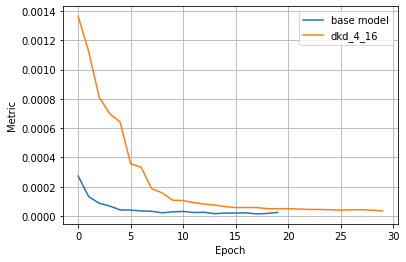

CURRENT METRIC VALUE: 3.427162575838206e-05
END OF EPOCH 29


In [ ]:
for n in range(dkd_config_4_16.num_epochs):

    train_epoch_distillation(model, model_dkd_4_16, opt, train_loader,
                distill_melspec_train, dkd_config_4_16.device, dkd_config_4_16.temperature, scheduler, dkd_config_4_16.alpha)

    au_fa_fr = validation(model_dkd_4_16, val_loader,
                          distill_melspec_val, dkd_config_4_16.device)
    history['dkd_4_16_val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'], label='base model')
    plt.plot(history['dkd_4_16_val_metric'], label='dkd_4_16')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()

    print('CURRENT METRIC VALUE:', au_fa_fr)
    print('END OF EPOCH', n)

In [ ]:
history['dkd_4_16_val_metric']

[0.0013651570710739394,
 0.0011250587616950878,
 0.0008127322401681298,
 0.0006991698096993833,
 0.0006420394929315145,
 0.00035678176723252445,
 0.0003332934999532293,
 0.0001866171479568385,
 0.00015833097242232155,
 0.00010735618098437979,
 0.00010470957363215231,
 9.131839686011516e-05,
 8.106316634195748e-05,
 7.480917647694191e-05,
 6.39392885579287e-05,
 5.693637147148236e-05,
 5.7559980193709574e-05,
 5.737200244490424e-05,
 4.976337927897405e-05,
 4.839681088289718e-05,
 4.9602255494283753e-05,
 4.687210247592057e-05,
 4.433291098015327e-05,
 4.4291138147085426e-05,
 4.242627952798489e-05,
 3.9666288771716096e-05,
 4.187428137673114e-05,
 4.242926330177546e-05,
 3.930525214305823e-05,
 3.427162575838206e-05]

In [ ]:
# torch.save(model_dkd_4_16.state_dict(), 'saved/student_dkd_4_16_model.pth')

### out channels 1, hidden size 32, gru layers 1

In [ ]:
torch.manual_seed(42)
use_gpu = torch.cuda.is_available()
if use_gpu:
    torch.cuda.manual_seed_all(42)

train_sampler = get_sampler(train_set.csv['label'].values)
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=64,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=64,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

dkd_config_1_32_1 = DistillationTaskConfig(batch_size=64, cnn_out_channels=1, hidden_size=32, kernel_size=(5, 20), stride=(2, 8), num_epochs=20, gru_num_layers=1, temperature=5, alpha=0.2)

In [ ]:
profile(CRNN(dkd_config_1_32_1).to(dkd_config_1_32_1.device), (torch.randn(128, 40, 101).to(dkd_config_1_32_1.device), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.baseline_model.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.baseline_model.CRNN'>. Treat it as zero Macs and zero Params.


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


(11398912.0, 6248.0)

In [ ]:
model_dkd_1_32_1 = CRNN(dkd_config_1_32_1).to(dkd_config_1_32_1.device)

opt = torch.optim.Adam(
    model_dkd_1_32_1.parameters(),
    lr=dkd_config_1_32_1.learning_rate,
    weight_decay=dkd_config_1_32_1.weight_decay
)

sum([p.numel() for p in model_dkd_1_32_1.parameters()])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


6248

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

distill_melspec_train = LogMelspec(is_train=True, config=dkd_config_1_32_1)
distill_melspec_val = LogMelspec(is_train=False, config=dkd_config_1_32_1)

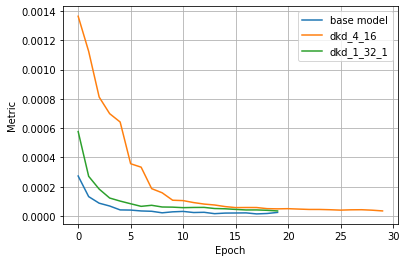

CURRENT METRIC VALUE: 3.40925993309484e-05
END OF EPOCH 19


In [ ]:
for n in range(dkd_config_1_32_1.num_epochs):

    train_epoch_distillation(model, model_dkd_1_32_1, opt, train_loader,
                distill_melspec_train, dkd_config_1_32_1.device, dkd_config_1_32_1.temperature, scheduler, dkd_config_1_32_1.alpha)

    au_fa_fr = validation(model_dkd_1_32_1, val_loader,
                          distill_melspec_val, dkd_config_1_32_1.device)
    history['dkd_1_32_1_val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'], label='base model')
    plt.plot(history['dkd_4_16_val_metric'], label='dkd_4_16')
    plt.plot(history['dkd_1_32_1_val_metric'], label='dkd_1_32_1')
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()

    print('CURRENT METRIC VALUE:', au_fa_fr)
    print('END OF EPOCH', n)

In [ ]:
# torch.save(model_dkd_1_32_1.state_dict(), 'saved/student_model_dkd_1_32_1.pth')